# <font color='orange'> SYDE 730 - Spatial Statistics </font>

In [ ]:
# Mount YOUR google drive. You'll need to "Add shortcut to Drive" for our shared folder for it to show up here.
# Use the URL shown below in the output to authorize this Colab session to access you GDrive
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
!pip install geopandas
!pip install geopy
!pip install pysal
!pip install splot
!pip install geoplot
!pip install -U plotly

In [ ]:
# Importing the requisite packages
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import pysal
import splot
import plotly.express as px
import numpy as np
import scipy
from scipy import stats as sts

# Read data

In [ ]:
# Setting the file path
data_path = '/content/drive/MyDrive/Courses/SYDE_740/Notebooks/AirBnB/listings.csv.gz'

In [ ]:
# Reading in the data - REMINDER: You'll need to download this data yourself from InsideAirbnb
listings = pd.read_csv(data_path, compression='gzip')

# Exploratory Data Analysis

In [ ]:
# Check what columns are available in the data
print(listings.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [ ]:
# Create a subset of the data with only the columns you want to work with
listings_sub = listings[['id','property_type','neighbourhood_cleansed', 'neighbourhood_group_cleansed','beds','bathrooms', 'price','latitude','longitude']]
listings_sub.head()

,id,property_type,neighbourhood_cleansed,neighbourhood_group_cleansed,beds,bathrooms,price,latitude,longitude
0,6713005,Private room in rental unit,Upper East Side,Manhattan,NaN,NaN,NaN,40.767510,-73.955170
1,922527181364298444,Entire rental unit,Flushing,Queens,2.0,1.0,$202.00,40.754404,-73.832370
2,794696802406920855,Entire rental unit,Hell's Kitchen,Manhattan,NaN,NaN,NaN,40.762272,-73.995836
3,54294086,Private room in rental unit,Jamaica,Queens,1.0,1.0,$342.00,40.697390,-73.792790
4,1039262508734112133,Private room in rental unit,East Elmhurst,Queens,1.0,1.0,$105.00,40.758789,-73.867923


## Remove irrelevant information

In [ ]:
# Check what data are missing
listings_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38199 entries, 0 to 38198
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            38199 non-null  int64  
 1   property_type                 38199 non-null  object 
 2   neighbourhood_cleansed        38199 non-null  object 
 3   neighbourhood_group_cleansed  38199 non-null  object 
 4   beds                          23490 non-null  float64
 5   bathrooms                     23634 non-null  float64
 6   price                         23634 non-null  object 
 7   latitude                      38199 non-null  float64
 8   longitude                     38199 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 2.6+ MB


In [ ]:
# Say our analysis cannot proceed unless we know the listing price
# In this case we must remove entries with missing listing price
# Note: there may be a pattern in the missing data that would make this step more complicated. We will ignore it for now.
listings_sub = listings_sub[listings_sub['price'].isna() == False].reset_index(drop=True)
listings_sub

,id,property_type,neighbourhood_cleansed,neighbourhood_group_cleansed,beds,bathrooms,price,latitude,longitude
0,922527181364298444,Entire rental unit,Flushing,Queens,2.0,1.0,$202.00,40.754404,-73.832370
1,54294086,Private room in rental unit,Jamaica,Queens,1.0,1.0,$342.00,40.697390,-73.792790
2,1039262508734112133,Private room in rental unit,East Elmhurst,Queens,1.0,1.0,$105.00,40.758789,-73.867923
3,1066034452713537152,Private room in home,East Elmhurst,Queens,1.0,1.0,$51.00,40.756429,-73.880817
4,25274961,Private room in home,Woodside,Queens,1.0,1.0,$125.00,40.754070,-73.901900
...,...,...,...,...,...,...,...,...,...
23629,1068368638122118305,Private room in townhouse,Coney Island,Brooklyn,0.0,1.0,$56.00,40.576880,-73.999450
23630,1081507139395912406,Private room in home,Todt Hill,Staten Island,1.0,1.0,$55.00,40.585590,-74.107130
23631,50257676,Private room in bungalow,Rockaway Beach,Queens,1.0,1.0,$99.00,40.588100,-73.814270
23632,21956264,Private room in rental unit,South Ozone Park,Queens,2.0,1.0,$47.00,40.672350,-73.797930


## Fix structural errors


In [ ]:
# Check the data types for each column
# If the data type is not what you would expect, there is likely something wrong
# Often, data type = object is a sign something is off because the column contain multiple data types
listings_sub.dtypes

id                                int64
property_type                    object
neighbourhood_cleansed           object
neighbourhood_group_cleansed     object
beds                            float64
bathrooms                       float64
price                            object
latitude                        float64
longitude                       float64
dtype: object

In [ ]:
listings_sub['price'].unique()

array(['$202.00', '$342.00', '$105.00', '$51.00', '$125.00', '$70.00',
       '$44.00', '$1,200.00', '$175.00', '$90.00', '$129.00', '$100.00',
       '$97.00', '$50.00', '$118.00', '$77.00', '$88.00', '$300.00',
       '$160.00', '$239.00', '$45.00', '$99.00', '$500.00', '$128.00',
       '$133.00', '$159.00', '$176.00', '$140.00', '$132.00', '$119.00',
       '$318.00', '$93.00', '$65.00', '$364.00', '$130.00', '$60.00',
       '$69.00', '$66.00', '$165.00', '$104.00', '$59.00', '$386.00',
       '$350.00', '$230.00', '$150.00', '$117.00', '$158.00', '$89.00',
       '$111.00', '$149.00', '$190.00', '$138.00', '$152.00', '$54.00',
       '$369.00', '$110.00', '$436.00', '$120.00', '$52.00', '$3,600.00',
       '$163.00', '$200.00', '$85.00', '$49.00', '$775.00', '$298.00',
       '$55.00', '$83.00', '$35.00', '$82.00', '$601.00', '$485.00',
       '$611.00', '$170.00', '$95.00', '$68.00', '$270.00', '$250.00',
       '$114.00', '$98.00', '$199.00', '$91.00', '$650.00', '$164.00',
   

In [ ]:
# The command below does a few things
# It casts each element of the series to a string (str)
# It strips the string of the items in the quotation marks
# Note, to strip ' we have to do "'", to remove " we need to do '"'
# Finally, it casts the series as type integer, astype(int)
listings_sub["price"] = listings_sub["price"].replace("[$,]", "", regex=True).astype(float)

In [ ]:
# Check types again
listings_sub.dtypes

id                                int64
property_type                    object
neighbourhood_cleansed           object
neighbourhood_group_cleansed     object
beds                            float64
bathrooms                       float64
price                           float64
latitude                        float64
longitude                       float64
dtype: object

In [ ]:
listings_sub['price'].describe()

count     23634.000000
mean        224.850470
std        1012.402874
min           8.000000
25%          84.000000
50%         143.000000
75%         248.000000
max      100000.000000
Name: price, dtype: float64

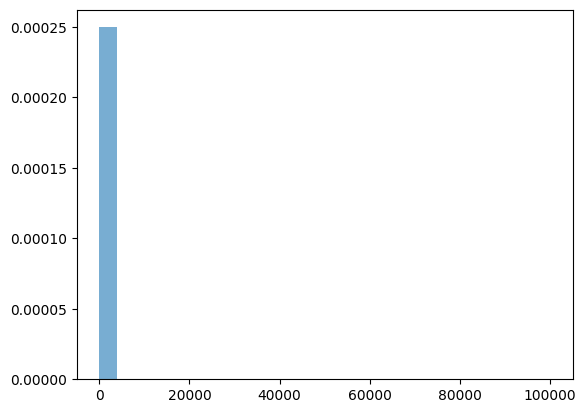

In [ ]:
%matplotlib inline
plt.hist(listings_sub['price'], bins=25, density=True, alpha=0.6)
plt.show()

<ipython-input-17-0c98bdba621c>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(listings_sub['price'], kde=True)


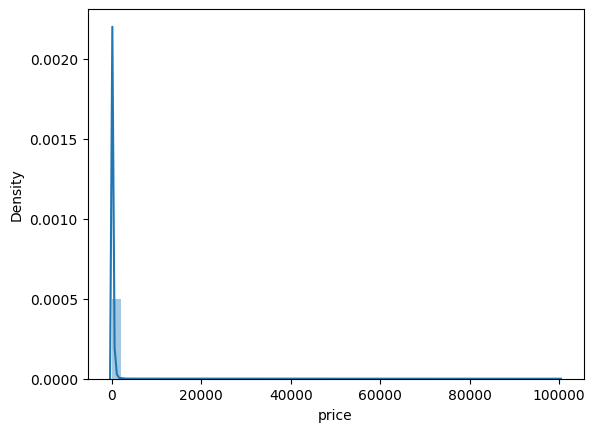

In [ ]:
import seaborn as sns
sns.distplot(listings_sub['price'], kde=True)
plt.show()

## Handle outliers

As you can see, the distribution is significantly skewed to the right due to outliers. If your objective is to understand general patterns in the data, one alternative is to eliminate the outliers.

In [ ]:
sorted_homeValues = listings_sub['price'].sort_values().reset_index(drop=True)

lower_quantile = sorted_homeValues[int(0.25*(len(sorted_homeValues)+1))] # or np.quantile(df_Alameda['HomeValue2022'],0.25)
upper_quantile = sorted_homeValues[int(0.75*(len(sorted_homeValues)+1))] # or np.quantile(df_Alameda['HomeValue2022'],0.75)
interquantile_range = upper_quantile - lower_quantile

lower_fence = lower_quantile - 3 * interquantile_range
upper_fence = upper_quantile + 3 * interquantile_range

print('Listing above', upper_fence, 'or more are outliers.')

Listing above 740.0 or more are outliers.


As you can see, few homes have outlier values. We have a few options.

1 - We can truncate our data and only work with the data below the upper fence.

2 - We can modify the data and reduce all values above the upper fence setting them at the upper fence.

Option 1 is easier and has small downsides if the number of samples above the upper fence is small. Let's check how many samples fall into this category:

In [ ]:
# The attribute "shape" of a dataframe returns the number of rows and number of columns in a series of size 2
print(listings_sub[listings_sub['price'] > upper_fence].shape)

# We can acess the row numbers by reading the value at the position [0] in this list
print('The number of samples with home value above the upper fence is', listings_sub[listings_sub['price'] > upper_fence].shape[0])

(705, 9)
The number of samples with home value above the upper fence is 705


There are 410 homes with home value above 2.5 million. What should we do about them?

array([[<Axes: title={'center': 'price'}>]], dtype=object)

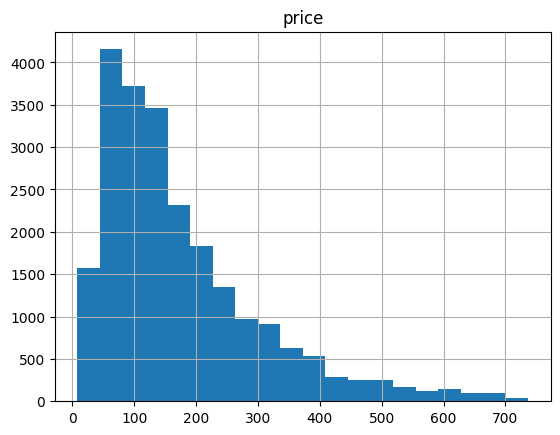

In [ ]:
# Select only the homes with home values < the upper fence to continue on
listings_sub = listings_sub[listings_sub['price'] <= upper_fence].copy().reset_index(drop=True)
listings_sub.hist(['price'],bins=20)

# <font color='orange'> Exploratory Spatial Data Analysis </font>

### Creating basic maps

In [ ]:
# Convert the pandas dataframe to a geopandas dataframe
listings_sub_gpd = gpd.GeoDataFrame(listings_sub, geometry=gpd.points_from_xy(listings_sub.longitude, listings_sub.latitude, crs=4326))

<GeoAxes: >

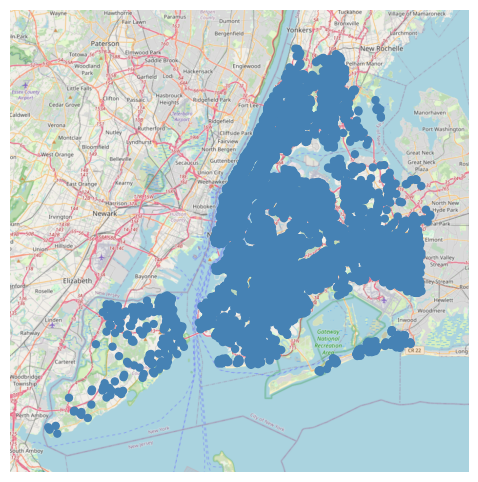

In [ ]:
import geoplot.crs as gcrs
import geoplot as gplt
ax = gplt.webmap(listings_sub_gpd,projection=gcrs.WebMercator())
gplt.pointplot(listings_sub_gpd, ax=ax)

In [ ]:
# Alternatively
fig = px.scatter_mapbox(listings_sub_gpd,
                        lat = listings_sub.latitude,
                        lon = listings_sub.longitude,
                        center={"lat": np.median(listings_sub.latitude), "lon": np.median(listings_sub.longitude)},
                        mapbox_style="carto-positron",
                        color = 'price',
                        color_continuous_scale='Sunset',
                        zoom=9,
                        height=700,
                        width=800
                      )
fig.show()

## <font color='orange'> Kernel Density Estimation </font>

### At sampled points

In [ ]:
df = listings_sub_gpd.sample(1000).reset_index(drop=True)

# Bandwidth
h = 0.05 #degrees

v_u = []
v_t = []
v_ep = []
v_n = []

for i in range(df.shape[0]):
  sum_u = 0
  sum_t = 0
  sum_ep = 0
  sum_n = 0
  for j in range(df.shape[0]):
      u = np.sqrt((df.loc[i,'latitude'] - df.loc[j,'latitude'])**2 + (df.loc[i,'longitude'] - df.loc[j,'longitude'])**2)

      # Check if within range
      if u < h:
          uh = u/h

          # https://en.wikipedia.org/wiki/Kernel_(statistics)#Kernel_functions_in_common_use

          # Uniform Kernel
          sum_u += 0.5

          # Triangular Kernel
          sum_t += 1 - np.abs(uh)

          # Epanechnikov Kernel
          sum_ep += (3/4)*(1 - uh**2)

      # Gaussian
      sum_n += (1/np.sqrt((2*np.pi)))*np.exp(-0.5*uh**2)


  v_u.append(sum_u/df.shape[0]/h)
  v_t.append(sum_t/df.shape[0]/h)
  v_ep.append(sum_ep/df.shape[0]/h)
  v_n.append(sum_n/df.shape[0]/h)


df['Kernel_u'] = v_u
df['Kernel_t'] = v_t
df['Kernel_ep'] = v_ep
df['Kernel_n'] = v_n
df.head(3)

,id,property_type,neighbourhood_cleansed,neighbourhood_group_cleansed,beds,bathrooms,price,latitude,longitude,geometry,Kernel_u,Kernel_t,Kernel_ep,Kernel_n
0,52219116,Shared room in rental unit,Kew Gardens,Queens,1.0,1.0,100.0,40.70840,-73.82665,POINT (-73.82665 40.70840),0.43,0.300759,0.328437,0.271281
1,819228,Private room in condo,Harlem,Manhattan,1.0,1.0,99.0,40.82097,-73.95412,POINT (-73.95412 40.82097),1.47,1.334482,1.386619,0.985163
2,672459717259106879,Entire rental unit,Woodhaven,Queens,2.0,1.0,231.0,40.69585,-73.85276,POINT (-73.85276 40.69585),0.50,0.353349,0.392748,0.317617


In [ ]:
fig = px.scatter_mapbox(df,
                        lat = df.latitude,
                        lon = df.longitude,
                        center={"lat": np.median(df.latitude), "lon": np.median(df.longitude)},
                        mapbox_style="carto-positron",
                        color = 'Kernel_ep',
                        color_continuous_scale='Sunset',
                        zoom=9,
                        height=700,
                        width=800
                      )
fig.show()

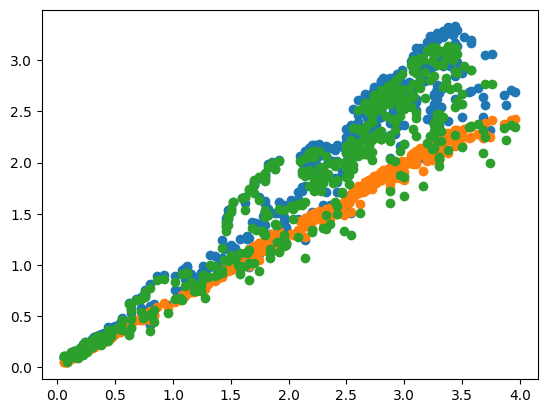

In [ ]:
plt.scatter(df['Kernel_u'],df['Kernel_ep'])
plt.scatter(df['Kernel_u'],df['Kernel_n'])
plt.scatter(df['Kernel_u'],df['Kernel_t'])

<GeoAxes: xlabel='None', ylabel='None'>

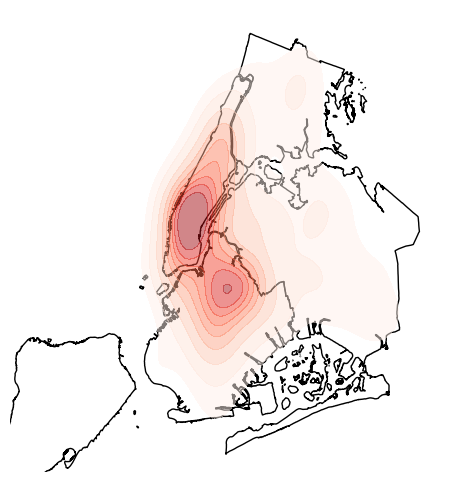

In [ ]:
# Get a map of NY boroughs
boroughs = gpd.read_file('/content/drive/MyDrive/Courses/SYDE_740/Notebooks/AirBnB/BoroughBoundaries/geo_export_8f8e1fec-01ff-4830-873a-18edf4297ecc.dbf')
ax = gplt.polyplot(boroughs, projection=gcrs.AlbersEqualArea(), zorder=1)

# Create a heat map with the data
gplt.kdeplot(df, cmap='Reds', fill=True, alpha=0.75, ax=ax)

# there is a an option (clip=boroughs) that should clip the heat maps at the boundaries of the boroughs polygons
# it works sometimes, sometimes it does not - I am not sure why

### At grid over entire area

In [ ]:
# import itertools package
import itertools
from itertools import permutations

# get the difference in latitute and longitude
min_lat = int(np.min(listings_sub_gpd.latitude)*10000)
min_lon = int(np.min(listings_sub_gpd.longitude)*10000)
max_lat = int(np.max(listings_sub_gpd.latitude)*10000)
max_lon = int(np.max(listings_sub_gpd.longitude)*10000)

range_lats = list(range(min_lat,max_lat,int((max_lat - min_lat)/20) + 1))
range_lons = list(range(min_lon,max_lon,int((max_lon - min_lon)/20) + 1))

range_lats = [i/10000 for i in range_lats]
range_lons = [i/10000 for i in range_lons]

df_grid = pd.DataFrame()

u = []
v = []
for i in range_lats:
    for j in range_lons:
        u.append(i)
        v.append(j)

df_grid['latitude'] = u
df_grid['longitude'] = v
df_grid.head(3)

,latitude,longitude
0,40.5003,-74.2519
1,40.5003,-74.2249
2,40.5003,-74.1979
3,40.5003,-74.1709
4,40.5003,-74.1439
...,...,...
395,40.8917,-73.8469
396,40.8917,-73.8199
397,40.8917,-73.7929
398,40.8917,-73.7659


In [ ]:
# Bandwidth
h = 0.05 #degrees

v_u = []
v_t = []
v_ep = []
v_n = []

for i in range(df_grid.shape[0]):
  sum_u = 0
  sum_t = 0
  sum_ep = 0
  sum_n = 0
  for j in range(df.shape[0]):
      u = np.sqrt((df_grid.loc[i,'latitude'] - df.loc[j,'latitude'])**2 + (df_grid.loc[i,'longitude'] - df.loc[j,'longitude'])**2)

      # Check if within bandwidth
      if u < h:
          uh = u/h

          # https://en.wikipedia.org/wiki/Kernel_(statistics)#Kernel_functions_in_common_use

          # Uniform Kernel
          sum_u += 0.5

          # Triangular Kernel
          sum_t += 1 - np.abs(uh)

          # Epanechnikov Kernel
          sum_ep += (3/4)*(1 - uh**2)

      # Normal
      sum_n += (1/np.sqrt((2*np.pi)))*np.exp(-0.5*uh**2)

  v_u.append(sum_u/df.shape[0]/h)
  v_t.append(sum_t/df.shape[0]/h)
  v_ep.append(sum_ep/df.shape[0]/h)
  v_n.append(sum_n/df.shape[0]/h)


df_grid['Kernel_u'] = v_u
df_grid['Kernel_t'] = v_t
df_grid['Kernel_ep'] = v_ep
df_grid['Kernel_n'] = v_n
df_grid.head(3)

,latitude,longitude,Kernel_u,Kernel_t,Kernel_ep,Kernel_n
0,40.5003,-74.2519,0.00,0.000000,0.000000,0.000000
1,40.5003,-74.2249,0.00,0.000000,0.000000,0.000000
2,40.5003,-74.1979,0.00,0.000000,0.000000,0.000000
3,40.5003,-74.1709,0.00,0.000000,0.000000,0.000000
4,40.5003,-74.1439,0.00,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
395,40.8917,-73.8469,0.18,0.148563,0.160007,0.118355
396,40.8917,-73.8199,0.10,0.061222,0.067663,0.061583
397,40.8917,-73.7929,0.04,0.006921,0.009831,0.021025
398,40.8917,-73.7659,0.00,0.000000,0.000000,0.000000


In [ ]:
df_plt = df_grid.copy() # df_Means contain the mean for each building for each scenario.

gdf_plt = gpd.GeoDataFrame(df_plt, geometry=gpd.points_from_xy(df_plt.longitude, df_plt.latitude), crs='epsg:4326')


fig = px.scatter_mapbox(gdf_plt,
                        lat = gdf_plt.latitude,
                        lon = gdf_plt.longitude,
                        center={"lat": np.median(gdf_plt.latitude), "lon": np.median(gdf_plt.longitude)},
                        mapbox_style="carto-positron",
                        color = 'Kernel_ep',
                        color_continuous_scale='Sunset',
                        zoom=9,
                        height=700,
                        width=800
                      )
fig.show()

### At selected grid

In [ ]:
# import itertools package
import itertools
from itertools import permutations

# get the difference in latitute and longitude
min_lat = int(40.60*10000)
min_lon = int(-74.09*10000)
max_lat = int(40.85*10000)
max_lon = int(-73.82*10000)

range_lats = list(range(min_lat,max_lat,int((max_lat - min_lat)/20) + 1))
range_lons = list(range(min_lon,max_lon,int((max_lon - min_lon)/20) + 1))

range_lats = [i/10000 for i in range_lats]
range_lons = [i/10000 for i in range_lons]

df_grid = pd.DataFrame()

u = []
v = []
for i in range_lats:
    for j in range_lons:
        u.append(i)
        v.append(j)

df_grid['latitude'] = u
df_grid['longitude'] = v
df_grid.head(3)

,latitude,longitude
0,40.6000,-74.0900
1,40.6000,-74.0764
2,40.6000,-74.0628
3,40.6000,-74.0492
4,40.6000,-74.0356
...,...,...
395,40.8394,-73.8860
396,40.8394,-73.8724
397,40.8394,-73.8588
398,40.8394,-73.8452


In [ ]:
# Bandwidth
h = 0.05 #degrees

v_u = []
v_t = []
v_ep = []
v_n = []

for i in range(df_grid.shape[0]):
  sum_u = 0
  sum_t = 0
  sum_ep = 0
  sum_n = 0
  for j in range(df.shape[0]):
      u = np.sqrt((df_grid.loc[i,'latitude'] - df.loc[j,'latitude'])**2 + (df_grid.loc[i,'longitude'] - df.loc[j,'longitude'])**2)

      # Check if within bandwidth
      if u < h:
          uh = u/h

          # https://en.wikipedia.org/wiki/Kernel_(statistics)#Kernel_functions_in_common_use

          # Uniform Kernel
          sum_u += 0.5

          # Triangular Kernel
          sum_t += 1 - np.abs(uh)

          # Epanechnikov Kernel
          sum_ep += (3/4)*(1 - uh**2)

      # Normal
      sum_n += (1/np.sqrt((2*np.pi)))*np.exp(-0.5*uh**2)

  v_u.append(sum_u/df.shape[0]/h)
  v_t.append(sum_t/df.shape[0]/h)
  v_ep.append(sum_ep/df.shape[0]/h)
  v_n.append(sum_n/df.shape[0]/h)


df_grid['Kernel_u'] = v_u
df_grid['Kernel_t'] = v_t
df_grid['Kernel_ep'] = v_ep
df_grid['Kernel_n'] = v_n
df_grid.head(3)

,latitude,longitude,Kernel_u,Kernel_t,Kernel_ep,Kernel_n
0,40.6000,-74.0900,0.14,0.081075,0.099731,0.086359
1,40.6000,-74.0764,0.12,0.058694,0.073703,0.071623
2,40.6000,-74.0628,0.12,0.052019,0.065552,0.070115
3,40.6000,-74.0492,0.14,0.077051,0.093827,0.085281
4,40.6000,-74.0356,0.20,0.112741,0.128902,0.121495
...,...,...,...,...,...,...
395,40.8394,-73.8860,0.36,0.205153,0.239854,0.219801
396,40.8394,-73.8724,0.28,0.187989,0.221416,0.177484
397,40.8394,-73.8588,0.28,0.179291,0.207331,0.175020
398,40.8394,-73.8452,0.22,0.168334,0.187250,0.142728


In [ ]:
df_plt = df_grid.copy() # df_Means contain the mean for each building for each scenario.

gdf_plt = gpd.GeoDataFrame(df_plt, geometry=gpd.points_from_xy(df_plt.longitude, df_plt.latitude), crs='epsg:4326')


fig = px.scatter_mapbox(gdf_plt,
                        lat = gdf_plt.latitude,
                        lon = gdf_plt.longitude,
                        center={"lat": np.median(gdf_plt.latitude), "lon": np.median(gdf_plt.longitude)},
                        mapbox_style="carto-positron",
                        color = 'Kernel_ep',
                        color_continuous_scale='Sunset',
                        zoom=9,
                        height=700,
                        width=800
                      )
fig.show()

## <font color='orange'> Quadtrees </font>



/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:4844: FutureWarning:

You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.



<GeoAxes: >

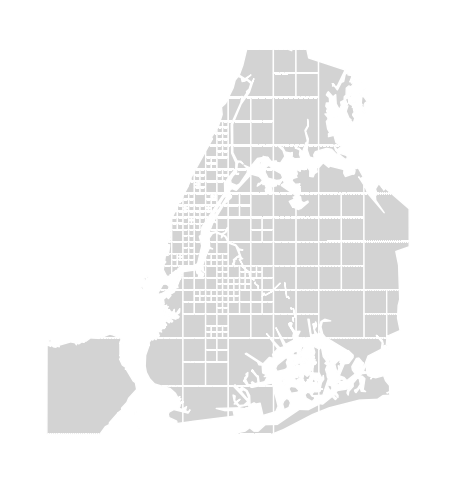

In [ ]:
gplt.quadtree(
    df, nmax=1,
    projection=gcrs.AlbersEqualArea(), clip=boroughs.simplify(0.001),
    facecolor='lightgray', edgecolor='white'
)

/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:4844: FutureWarning:

You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.



<GeoAxes: >

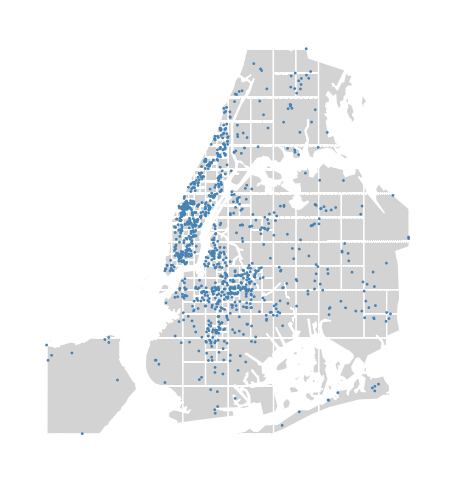

In [ ]:
ax = gplt.quadtree(
    df, nmax=1,
    projection=gcrs.AlbersEqualArea(), clip=boroughs.simplify(0.001),
    facecolor='lightgray', edgecolor='white', zorder=0
)
gplt.pointplot(df, s=1, ax=ax)

Use hue to add color as a visual variable to the plot. cmap controls the colormap used. legend toggles the legend. The individual values of the points included in the partitions are aggregated, and each partition is colormapped based on this aggregate value.

This type of plot is an effective gauge of distribution: the less random the plot output, the more spatially correlated the variable.

The default aggregation function is np.mean, but you can configure the aggregation by passing a different function to agg.

/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:4844: FutureWarning:

You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.



<GeoAxes: >

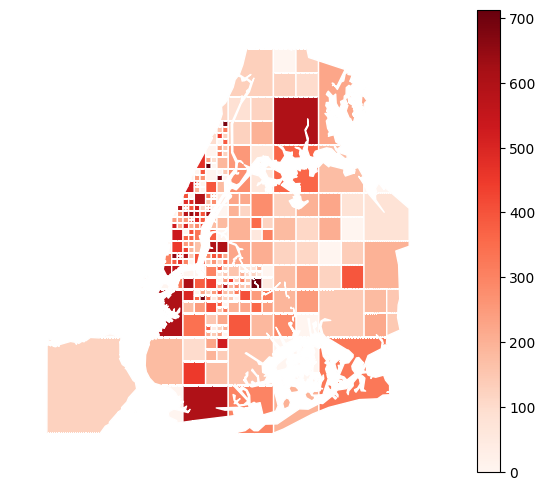

In [ ]:
gplt.quadtree(
    df, nmax=1, agg=np.max,
    projection=gcrs.AlbersEqualArea(), clip=boroughs.simplify(0.001),
    hue='price', cmap='Reds',
    edgecolor='white', legend=True
)

/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:4844: FutureWarning:

You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.



<GeoAxes: >

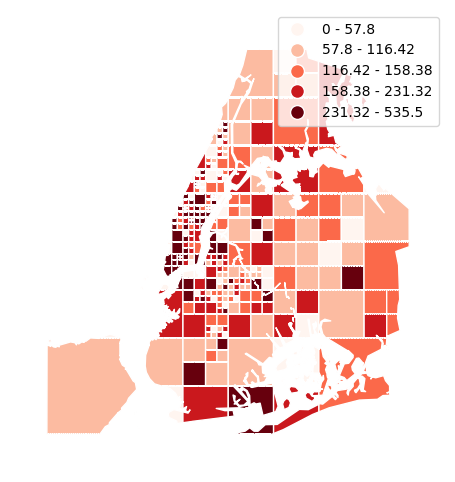

In [ ]:
gplt.quadtree(
    df, nmax=1,
    projection=gcrs.AlbersEqualArea(), clip=boroughs.simplify(0.001),
    hue='price', cmap='Reds',
    edgecolor='white', legend=True, scheme='Quantiles'
)